# 5.3.4 텐서플로 2.0과 케라스를 이용한 영화 리뷰 긍부정(감정) 분석

- 작성자: [김찬란](https://github.com/seriousran)

In [0]:
# 코드 5-19 패키지 설치 및 데이터셋 다운로드

!git clone https://github.com/kpe/bert-for-tf2.git
!pip install -r bert-for-tf2/requirements.txt
!pip install sentencepiece

!git clone https://github.com/e9t/nsmc
!wget https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip
!unzip multi_cased_L-12_H-768_A-12.zip
#!pip install ujson

import sys
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

sys.path.append("bert-for-tf2/")

import tensorflow as tf
import keras

import bert
from bert.model import BertModelLayer
from bert.loader import params_from_pretrained_ckpt, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

fatal: destination path 'bert-for-tf2' already exists and is not an empty directory.
fatal: destination path 'nsmc' already exists and is not an empty directory.
--2020-02-07 00:56:04--  https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 2607:f8b0:400e:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662903077 (632M) [application/zip]
Saving to: ‘multi_cased_L-12_H-768_A-12.zip.1’

multi_cased_L-12_H- 100%[===================>] 632.19M  47.6MB/s    in 13s     

2020-02-07 00:56:17 (50.3 MB/s) - ‘multi_cased_L-12_H-768_A-12.zip.1’ saved [662903077/662903077]

Archive:  multi_cased_L-12_H-768_A-12.zip
replace multi_cased_L-12_H-768_A-12/bert_model.ckpt.meta? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


Using TensorFlow backend.


In [0]:
df_train = pd.read_csv("nsmc/ratings_train.txt", sep='\t', nrows=10000)
df_test = pd.read_csv("nsmc/ratings_test.txt", sep='\t', nrows=10000)
df_train.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [0]:
# 코드 5-20 데이터셋 임의 순열

data_train = df_train[['label', 'document']].values
data_test = df_test[['label', 'document']].values

shuffled_train = random.sample(list(data_train), len(data_train))
training_set = shuffled_train
shuffled_test = random.sample(list(data_test), len(data_test))
testing_set = shuffled_test

SEQ_LEN = 256
CLASS = 2

In [0]:
# 코드 5-21 BERT를 위한 토크나이징

tokenizer = FullTokenizer('multi_cased_L-12_H-768_A-12/vocab.txt', do_lower_case=False)

train_tokens = []
for row in training_set:
  train_tokens.append( ["[CLS]"] + tokenizer.tokenize(str(row[1])) + ["[SEP]"] )

train_token_ids = list(map(tokenizer.convert_tokens_to_ids, train_tokens))
train_token_ids = map(lambda tids: tids + [0] * (SEQ_LEN - len(tids)), train_token_ids)
train_token_ids = np.array([np.array(xi) for xi in list(train_token_ids)])

test_tokens = []
for row in testing_set:
  test_tokens.append( ["[CLS]"] + tokenizer.tokenize(str(row[1])) + ["[SEP]"] )

test_token_ids = list(map(tokenizer.convert_tokens_to_ids, test_tokens))
test_token_ids = map(lambda tids: tids + [0] * (SEQ_LEN - len(tids)), test_token_ids)
test_token_ids = np.array([np.array(xi) for xi in list(test_token_ids)])

x_train = train_token_ids
y_train = np.array(training_set)[:,0]
x_test = test_token_ids
y_test =  np.array(testing_set)[:,0]

In [0]:
# 5-22 BERT 기반의 분류 모델 생성

from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

bert_params = params_from_pretrained_ckpt("multi_cased_L-12_H-768_A-12")
bert_layer = BertModelLayer.from_params(bert_params, name="bert")
bert_layer.apply_adapter_freeze()

def create_model(max_seq_length, classes):
  inputs = Input(shape=(max_seq_length,), dtype='int32', name='input_ids')
  bert = bert_layer(inputs)
  cls_out = Lambda(lambda seq: seq[:, 0, :])(bert)
  dr_1 = Dropout(0.3)(cls_out)
  fc_1 = Dense(256, activation=tf.nn.relu)(dr_1)
  dr_2 = Dropout(0.3)(fc_1)
  outputs = Dense(classes, activation='softmax')(dr_2)

  model = Model(inputs, outputs)

  return model

model = create_model(SEQ_LEN, CLASS)
model.build(input_shape=(None, SEQ_LEN))

load_stock_weights(bert_layer, "multi_cased_L-12_H-768_A-12/bert_model.ckpt")

def flatten_layers(root_layer):
    if isinstance(root_layer, keras.layers.Layer):
        yield root_layer
    for layer in root_layer._layers:
        for sub_layer in flatten_layers(layer):
            yield sub_layer

for layer in flatten_layers(bert_layer):
        if layer.name in ["LayerNorm", "adapter-down", "adapter-up"]:
            layer.trainable = True
        else:
            layer.trainable = False

bert_layer.embeddings_layer.trainable = False

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.00001), metrics=['accuracy'])

print(model.summary())

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Done loading 196 BERT weights from: multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fd45ad61b70> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Model: "model"
______________________________

In [0]:
# 코드 5-23 콜백을 활용한 모델 학습

checkpointName = "bert_fine-tuning.ckpt"

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpointName,
                                                  save_weights_only=True,
                                                  verbose=1)

history = model.fit(x_train, y_train, 
                    epochs=4, batch_size=16,
                    validation_data=(x_test, y_test),
                    verbose=1, callbacks=[cp_callback]
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 10000 samples, validate on 10000 samples
Epoch 1/4
 9984/10000 [============================>.] - ETA: 0s - loss: 0.6464 - acc: 0.6074
Epoch 00001: saving model to bert_fine-tuning.ckpt
10000/10000 [==============================] - 456s 46ms/sample - loss: 0.6462 - acc: 0.6075 - val_loss: 0.5222 - val_acc: 0.7364
Epoch 2/4
 9984/10000 [============================>.] - ETA: 0s - loss: 0.4732 - acc: 0.7785
Epoch 00002: saving model to bert_fine-tuning.ckpt
10000/10000 [==============================] - 448s 45ms/sample - loss: 0.4737 - acc: 0.7784 - val_loss: 0.4378 - val_acc: 0.7904
Epoch 3/4
 9984/10000 [============================>.] - ETA: 0s - loss: 0.3692 - acc: 0.8375
Epoch 00003: saving model to bert_fine-tuning.ckpt
10000/10000 [==============================] - 448s 45ms/sample - loss: 0.3689 - acc: 0.8375 - val_loss: 0.4333 - val_acc: 0.8030
Epoch 4/4
 9984/10000 [========

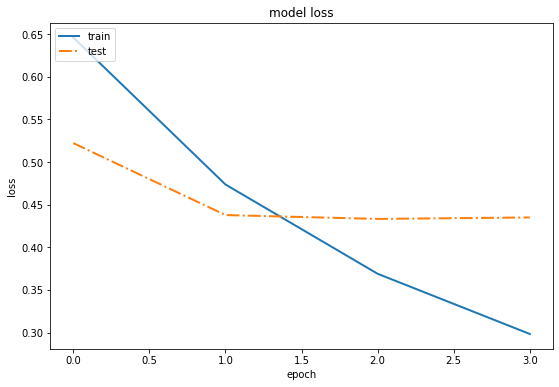

In [0]:
# 코드 5-24 결과 그래프 그리기 

plt.figure(figsize=(9,6))
plt.plot(history.history['loss'], '-', linewidth=2)
plt.plot(history.history['val_loss'], '-.', linewidth=2)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

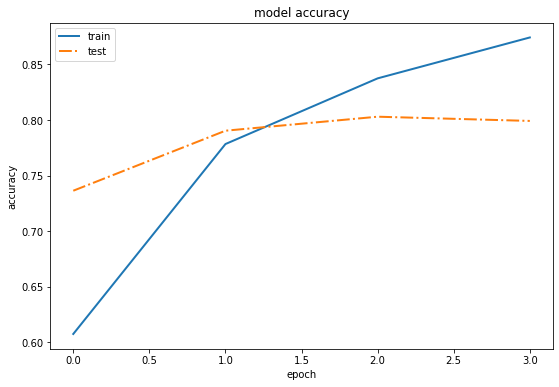

In [0]:
plt.figure(figsize=(9,6))
plt.plot(history.history['acc'], '-', linewidth=2)
plt.plot(history.history['val_acc'], '-.', linewidth=2)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()